In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import qstock as qs

import talib

import cvxopt as opt
from cvxopt import blas,solvers
solvers.options['show_progress'] = False #求解器只输出结果不打印过程
from scipy.optimize import minimize
# 需要计算或填充的变量：
# 账面市值比（PB倒数）
# 流通市值
# 息税前利润
# 股东权益合计（不含少数股东）
# 总资产
# 收盘价
import cvxpy as cp
import mysql.connector
import scipy.optimize as sco
from sklearn.linear_model import LinearRegression
from scipy.stats import zscore

提取各项数据

In [2]:
mydb = mysql.connector.connect(
      host="172.31.50.91",
      user="guest",
      password="MH#123456",
       database="astocks"
    )
query1 = "SELECT td, chg,close, codenum,total_share,float_share,vol FROM market WHERE td >= 20100101"

df1 = pd.read_sql(query1, mydb)
df1 = df1.sort_values(by=['td'])

query2 = "SELECT fd,codenum, total_assets,total_liabilities,EBIT,total_shareholders_equity,net_profit FROM finance WHERE fd >= 20091231"

df2 = pd.read_sql(query2, mydb)
df2 = df2.sort_values(by=['fd'])

query_deriv = "SELECT fd,codenum,EPS FROM finance_deriv WHERE fd >= 20091231"

df_deriv = pd.read_sql(query_deriv, mydb)
df_deriv = df_deriv.sort_values(by=['fd'])

df2 = pd.merge(df_deriv, df2, on=['codenum', 'fd'], how='outer')

C:\Users\19550\AppData\Local\Temp\ipykernel_6376\3168798985.py:9: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df1 = pd.read_sql(query1, mydb)
C:\Users\19550\AppData\Local\Temp\ipykernel_6376\3168798985.py:14: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df2 = pd.read_sql(query2, mydb)
C:\Users\19550\AppData\Local\Temp\ipykernel_6376\3168798985.py:19: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_deriv = pd.read_sql(query_deriv, mydb)


In [6]:
query3 = "SELECT td, chg,codenum FROM market WHERE td >= 20100101"

df3 = pd.read_sql(query3, mydb)
df3 = df3.sort_values(by=['td'])

C:\Users\19550\AppData\Local\Temp\ipykernel_6376\1535748614.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df3 = pd.read_sql(query3, mydb)


In [3]:
df1 = df1.reset_index(drop = True)
df2 = df2.reset_index(drop = True)
df2['td'] = df2['fd']

merged_df = pd.merge(df1, df2, on=['codenum', 'td'], how='outer')
merged_df = merged_df.sort_values(['codenum','td'], ascending=True)
merged_df['total_assets'].fillna(method='ffill', inplace=True)
merged_df['total_liabilities'].fillna(method='ffill', inplace=True)
merged_df['EBIT'].fillna(method='ffill', inplace=True)
merged_df['EPS'].fillna(method='ffill', inplace=True)
merged_df['total_shareholders_equity'].fillna(method='ffill', inplace=True)
merged_df['net_profit'].fillna(method='ffill', inplace=True)

In [4]:
merged_df = merged_df.drop(columns=['fd'])
merged_df = merged_df.dropna()
# 计算（Book-to-Market Ratio）
merged_df['Book_Value'] = (merged_df['total_assets']-merged_df['total_liabilities'])
merged_df['Book_to_Market_Ratio'] = merged_df['Book_Value']/(merged_df['close'] * merged_df['total_share'])
# 计算流通市值（Market Capitalization）
merged_df['Market_Cap'] = merged_df['close'] * merged_df['float_share']
#计算PE ROE
merged_df['PE'] = merged_df['close']/merged_df['EPS']
merged_df['ROE'] = merged_df['net_profit']/merged_df['total_shareholders_equity']

In [7]:
#已计算完成的变量
cap=merged_df.pivot(index='td', columns='codenum', values='Market_Cap')
close=merged_df.pivot(index='td', columns='codenum', values='close')
bm=merged_df.pivot(index='td', columns='codenum', values='Book_to_Market_Ratio')
ebit=merged_df.pivot(index='td', columns='codenum', values='EBIT')
equity=merged_df.pivot(index='td', columns='codenum', values='total_shareholders_equity')
totasset=merged_df.pivot(index='td', columns='codenum', values='total_assets')
chg = df3.pivot(index='td', columns='codenum', values='chg')
chg = chg. fillna(0)
totasset = totasset.fillna(0)
daily_ret_matrix = close.pct_change(-1).fillna(0)
# daily_ret_matrix



具体分组

In [8]:
#提取构造时间序列以提取特定日期的数据
floatlist=cap.index
#index转化为str
datelist=pd.to_datetime(floatlist.astype("int").astype("str"))

#ALLapool可交易股票池
allapool=pd.DataFrame(index=floatlist,columns=cap.columns)
allapool[close>0]=1
allapool=allapool.fillna(0)
#allapool为构建的有效股票池（可以交易的股票），除去了缺失值

bm.set_index(floatlist,inplace=True)
totasset.set_index(floatlist,inplace=True)


#因子构建

bm=bm*allapool#将bm中不可交易的股票去除
cap=cap*allapool#将市值中不可交易的股票去除
pro=(ebit/equity)*allapool #构造盈利能力指标、将盈利能力中不可交易的股票去除

totasset=totasset*allapool#将总资产中不可交易的股票去除


#提取不同数据集相应月份的数据，对应五因子构造
cap_d=cap.set_index(datelist)
cap_m=cap_d.groupby([cap_d.index.year,cap_d.index.month]).tail(1)
# cap_may=cap_m[cap_m.index.month==5]

bm_d=bm.set_index(datelist)
bm_m=bm_d.groupby([bm_d.index.year,bm_d.index.month]).tail(1)
# bm_may=bm_m[bm_m.index.month==5]

pro_d=pro.set_index(datelist)
pro_m=pro_d.groupby([pro_d.index.year,pro_d.index.month]).tail(1)
# pro_may=pro_m[pro_m.index.month==5]

totasset_d=totasset.set_index(datelist)
totasset_m= totasset_d.groupby([totasset_d.index.year,totasset_d.index.month]).tail(1)
totasset_dec =totasset_m[totasset_m.index.month==12]

inv = (totasset_dec.shift(-1)-totasset_dec)/totasset_dec
inv = pd.DataFrame(inv,index=totasset_d.index,columns=totasset.columns)
inv = inv.fillna(method='ffill') 
inv.replace([np.inf, -np.inf], 0, inplace=True)
inv_m = inv.groupby([inv.index.year,inv.index.month]).tail(1)
# inv_may = inv_may[ (inv_may.index.month==5) ]
#因子选股
H=bm_m.apply(lambda x:(x>= x.quantile(0.7)),axis=1)#选取bm前百分之30的股票组合
M=bm_m.apply(lambda x:(x>=x.quantile(0.3))&(x<x.quantile(0.7)),axis=1)#选取bm值30%-70%的股票组合
L=bm_m.apply(lambda x:x<x.quantile(0.3),axis=1)#选取bm后百分之30的股票组合
#以下同上
B=cap_m.apply(lambda x:x>=x.quantile(0.5),axis=1)
S=cap_m.apply(lambda x:(x<x.quantile(0.5)),axis=1)

R=pro_m.apply(lambda x:(x>=x.quantile(0.7)),axis=1)
W=pro_m.apply(lambda x:x<x.quantile(0.2),axis=1)

A=inv_m.apply(lambda x:(x>=x.quantile(0.7)),axis=1)
C=inv_m.apply(lambda x:x<x.quantile(0.3),axis=1)


In [9]:
pe = merged_df.pivot(index='td', columns='codenum', values='PE')
pe = pe * allapool
pe = pe.fillna(10e5)
roe = merged_df.pivot(index='td', columns='codenum', values='ROE')
roe = roe * allapool
roe = roe.fillna(0)

In [10]:
pe_d=pe.set_index(datelist)
pe_m=pe_d.groupby([pe_d.index.year,pe_d.index.month]).tail(1)

pe_d[pe_d < 0] = 100000

roe_d=roe.set_index(datelist)
roe_m=roe_d.groupby([roe_d.index.year,roe_d.index.month]).tail(1)


In [27]:
pe_m = pe_m.fillna(0)
pe_m_z = pe_m.apply(zscore)
bm_m = bm_m.fillna(0)
bm_m_z = bm_m.apply(zscore)
pro_m = pro_m.fillna(0)
pro_m_z = pro_m.apply(zscore)
inv_m = inv_m.fillna(0)
inv_m_z = inv_m.apply(zscore)
cap_m = cap_m.fillna(0)
cap_m_z = cap_m.apply(zscore)
pe_m_m = pe_m.fillna(0)
pe_m_z = pe_m.apply(zscore)

#取小于等于20的PE和大于等一10%的ROE
PE_20 = pe_m.apply(lambda x:(((x>0) & (x <= 20)) | (x<=x.quantile(0.2))),axis=1)
ROE_15 = roe_m.apply(lambda x:(((x>=0.1) ) | (x>=x.quantile(0.5))),axis=1)

C:\Users\19550\anaconda3\Lib\site-packages\numpy\core\_methods.py:236: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


构建方程

In [11]:
 #市值加权持仓函数,根据每月数据计算日频持仓
def to_integer(dt_time):
    return 10000*dt_time.year + 100*dt_time.month + dt_time.day

#接受股票列表，按总资产比例计算并输出权重
def get_score(stocklist):
    pos=pd.DataFrame(stocklist,index=cap_d[(cap_d.index>= (stocklist.index[0])) & (cap_d.index<= (stocklist.index[-1]))].index,columns=cap.columns)
    pos=pos.fillna(method="ffill")
    pos=pos.set_index(to_integer(pos.index))
    pos=pos*allapool[(allapool.index>= (pos.index[0])) & (allapool.index<= (pos.index[-1]))]
    #根据市值加权计算持股比例
    cap_temp = cap[(cap.index>= (pos.index[0])) & (cap.index<= (pos.index[-1]))]
    score=((pos*cap_temp).T/(pos*cap_temp).sum(axis=1)).T
    return score
#把每日百分比收益率转化成每日累计收益
def bmk(df):
#     df.index=datelist
    df1=df["close"].pct_change()
    df1=(df1+1).cumprod()
    return df1

#马科维茨优化持股
def opt_portfolio(returns):
    n = len(returns)
    returns = np.asmatrix(returns)
    if n == 1:
        return [1]
    N = 100
    mus = [10** (5.0 * t/N - 1.0) for t in range(N)]
    
    S,pbar = opt.matrix(np.cov(returns)),opt.matrix(np.mean(returns,axis =1))

    G = -opt.matrix(np.eye(n))
    h = opt.matrix(0.0,(n,1))
    A = opt.matrix(1.0,(1,n))
    b = opt.matrix(1.0)

    portfolios = [solvers.qp(mu * S,-pbar,G,h,A,b)['x'] for mu in mus]

    returns = [blas.dot(pbar,x) for x in portfolios]
    risks = [np.sqrt(blas.dot(x,S*x)) for x in portfolios]
    m1 = np.polyfit(returns,risks,2)
    x1 = np.sqrt(m1[2]/m1[0])

    weights = solvers.qp(opt.matrix(x1*S),-pbar,G,h,A,b) ['x']
    return np.asarray(weights),returns,risks

#输出图像，我用了qstock的沪深300，因为周末无法用内网；只要用国内网络即可，不要挂代理
def plot1(a,na):
    plt.rcParams['figure.figsize'] = (10, 6)
    plt.xlabel("time")
    plt.ylabel("return")
    #修改原数据的index
    try:
        a.index=pd.to_datetime(a.index.astype("int").astype("str"))
    except:
        pass
   
    time = str(a.index[0])
    end_time = str(a.index[-1])
    all_data=benchmark[(benchmark.index >= a.index[0])&(benchmark.index <= a.index[-1])]
    benchmark1 = (all_data.pct_change()+1).cumprod()
    
    plt.plot(benchmark1,label="benchmark")
    plt.plot(a,label=na)
    plt.grid()
    plt.show()

#输出年夏普比率
def sharpe_ratio_yearly(data):
    temp = data.pct_change(1).values[1:]
    return temp.mean()/ temp.std() *255**0.5

#输出最大回撤
def calculate_drawdown(cumulative_returns):
    """
    计算最大回撤
    :param returns: 收益率数组
    :return: 最大回撤
    """
    
    # 计算历史峰值
    historical_peak = np.maximum.accumulate(cumulative_returns)
    
    # 计算回撤
    drawdown = (cumulative_returns - historical_peak) / historical_peak
    
    # 计算最大回撤(最小增幅)
    max_drawdown = np.min(drawdown)
    
    return max_drawdown
all_data=qs.get_data(code_list=['sh'],start='20090101',fqt=2)
benchmark = bmk(all_data)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.68it/s]


In [21]:

#计算置信度
def cal_IR(y):
    x = benchmark[(benchmark.index >= ret_SRHA.index[0]) &(benchmark.index <= ret_SRHA.index[-1])]
    dif = (y.pct_change()-x.pct_change())[1:]
    return sum(dif)/len(dif)/np.std(dif)
#计算与基准相比的每日胜率
def cal_win_rate(y):
    x = benchmark[(benchmark.index >= y.index[0]) &(benchmark.index <= y.index[-1])]
    x_ = x.pct_change()[1:]+1
    y_ = y.pct_change()[1:]+1
    count = sum(b >= a for a, b in zip(x_, y_))
    return float(count)/len(x_)
    
#计算一段时间的alpha与beta
def cal_alpha(y):
    for i in y.values:
        if np.isnan(i):
            return [0,0]
    x = benchmark[(benchmark.index >= y.index[0]) &(benchmark.index <= y.index[-1])]
    x_ = x.pct_change()[1:]+1
    y_ = y.pct_change()[1:]+1
    x_ = x_.reset_index(drop = True)
    y_ = y_.reset_index(drop = True)
    intervals_x = x_.groupby((x_.index // 5) * 5)
    intervals_y = y_.groupby((y_.index // 5) * 5)
    Beta2 = np.cov(intervals_x.prod(),intervals_y.prod())[0,1]/np.var(intervals_x.prod())
    Alpha2 = (y[-1]/y[0])**(260/len(y))-1 - Beta2 * ((x[-1]/x[0])**(260/len(y))-1)
    # print('Beta: ',Beta2," Alpha: ",Alpha2)
    return Alpha2,Beta2
    
#计算一段时间的每周alpha并输出列表
def cal_alpha_weekly(y):
    lis = []
    for i in range(0,len(y)-21,20):
        
        temp_y = y.iloc[i:i+21]
        lis +=  [cal_alpha(temp_y)]
    return lis

In [42]:

#优化器计算持股比例
def opt_min_risk(stocklist):
    pos=pd.DataFrame(stocklist,index=cap_m[(cap_m.index>= (stocklist.index[0])) & (cap_m.index<= (stocklist.index[-1]))].index,columns=cap.columns)
    pos = pos.set_index(pos.index.strftime("%Y%m%d").astype('int64'))
    for index, row in pos.iterrows():
        #得到可选的股票列表
        stock_list = row[row == 1 ].index.tolist()

        #打印日期和选股列表
        print(index)
        print(stock_list)
        #如果没有股票满足要求则跳到下一个月
        len1 = len(stock_list)
        if len1 == 0:
            continue
        
        #获取每一支股票前一段时间的回报率，此处选择20天  
        input =  daily_ret_matrix[(daily_ret_matrix.index <= index)][stock_list].tail(20) 
        #获取每一支股票前20天的收盘价
        close_temp = close[close.index <= index][stock_list].tail(20)
        close_temp = close_temp.set_index(pd.to_datetime(close_temp.index, format='%Y%m%d'))

        #收集所选股票前20天综合表现的alpha
        input1 = []
        for i in stock_list:
            input1 += [cal_alpha(close_temp[i])[0]]
        input1 = np.array([input1])
        input1 = pd.DataFrame(input1,columns = stock_list,index = [index])
        # bm_m pro_m inv_m roe_m| cap_m pe_m  

        

        # 生成日协方差
        daily_r_cov = input.cov()
        # 转化成年协方差
        cov_annualized = np.array(daily_r_cov * 252)
        
        #生成总资产权重
        cap_temp = cap[cap.index == index][stock_list].values
        cap_temp = cap_temp / np.sum(cap_temp)
        
        
        # create cvxpy variable to minimize
        w = cp.Variable(len(stock_list))
        bi_indicator = cp.Variable(len(stock_list),boolean = True)
        
        
        #目标：最大化 （预期alpha-波动）
        obj = cp.Maximize( 1 *(w.T @ input1.T)  - 1/2 * (w.T @ daily_r_cov @ w))
        #约束：权重非负；权重和为一；权重不超过总资产比例的1.1倍
        const = [
            cp.sum(w) == 1, w >= 0,
            w <= 1.1 * cap_temp[0],
        ]
        #尝试优化；如果报错则换为总资产权重
        try:
        # solve it!
            prob = cp.Problem(obj, const)
            opt_v = prob.solve(solver = 'CPLEX',reoptimize=True,verbose=False)
            
            # risk_opt = (opt_v * 252) ** 0.5
            w_opt = w.value
            
            # print('optimal risk (%):', risk_opt)
            # print('optimal proportion:', np.round(w_opt, 4))
        except:
            w_opt = cap_temp[0]
           
        weights = pd.DataFrame([np.round(w_opt, 4)],columns = input.columns,index = [index])
        pos.update(weights)
    
    pos=pos.reindex(floatlist[(floatlist>= pos.index[0]) & (floatlist<= pos.index[-1])])
    pos=pos.fillna(method="ffill")
    
    pos=pos*allapool[(allapool.index>= pos.index[0]) & (allapool.index<=pos.index[-1])]
    return pos


In [30]:
#构造收益曲线；选取列表内的分组的并集构造选股策略
#type是分配权重方式：get是按总资产分配，opt1是优化器分配
def output_ret(lis,type):
    temp = lis[0]
    for i in lis[1:]:
        temp = temp &i
    temp= temp * 1
    if type == 'get':
        score = get_score(temp)
    # score = opt_score(temp)
    elif type == 'opt1':
        score = opt_min_risk(temp)
        
    score=score.loc[~score.isna().all(axis=1)]
    ret=(chg.loc[score.index].shift(-1)*score).sum(axis=1)
    
    # ret=(ret/100+1).cumprod()
    ret = ret/100
    ret = loss_ending(ret,0.15)
    ret=(ret+1).cumprod()
    return ret
#构造benchmark
def bmk(df):
#     df.index=datelist
    df=df["close"].pct_change()
    df=(df+1).cumprod()
    return df

In [31]:
import copy
#止损机制
def loss_ending(y,max_drawback):
    y_temp = copy.deepcopy(y)
    y_temp.index = pd.to_datetime(y.index, format='%Y%m%d')
    y_temp = (y_temp +1).cumprod()
    for _, month_data in y_temp.resample('M'):
        historical_peak = ( np.maximum.accumulate(month_data))
        drawdown = (historical_peak - month_data) / historical_peak
        sell_all = False
        for idx, value in drawdown.items():
            if value >= max_drawback:
                sell_all = True
            if sell_all:
                y[int(idx.strftime('%Y%m%d'))] = 0         
    return y

输出图像

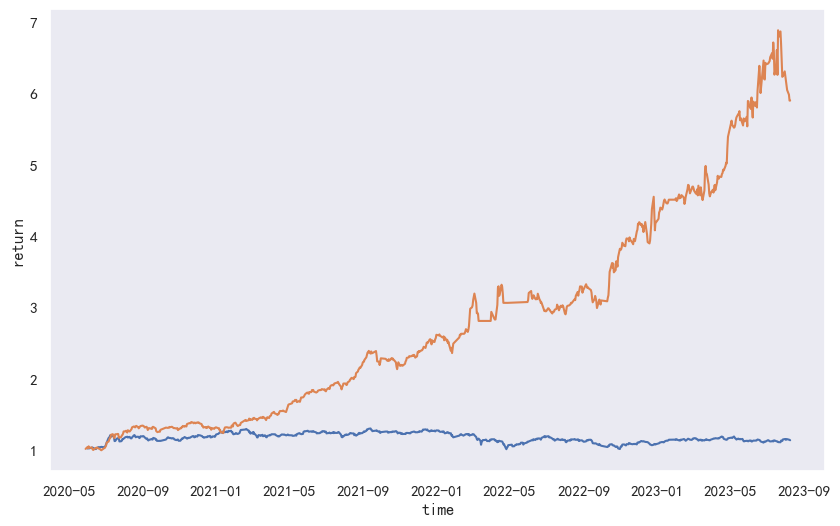

Sharpe:  2.3668800945429656
Drawdown: -0.1432580237116764
年化： 0.8385242597122815
Alpha:  0.7805275073841319  Beta:  0.44829624454239014
IR:  0.11298477860420916
mean weekly alpha:  1.0357935883130314 , week alpha std:  1.6717239600086864
Win rate: 0.5096525096525096


In [44]:
ret_SRHA=output_ret([S[-40:],R[-40:],H[-40:],PE_20[-40:],ROE_15[-40:]],'get')
plot1(ret_SRHA,'SRHA')
print('Sharpe: ',sharpe_ratio_yearly(ret_SRHA))
print('Drawdown:',calculate_drawdown(ret_SRHA.values)
print('年化：',ret_SRHA[-1]**(260/len(ret_SRHA))-1)
x,y = benchmark[(benchmark.index >= ret_SRHA.index[0]) &(benchmark.index <= ret_SRHA.index[-1])],ret_SRHA
y = y.reindex(x.index,method= 'ffill')
print('Alpha: ',cal_alpha(y)[0],' Beta: ',cal_alpha(y)[1])
print('IR: ', cal_IR(y))
print('mean weekly alpha: ',np.mean(cal_alpha_weekly(y)),', week alpha std: ',np.std(cal_alpha_weekly(y)))
print('Win rate:',cal_win_rate(y))